# Experimento: Clasificación de asuntos administrativos con GPT-4.1-mini

## Descripción general

En esta notebook se evalúa el uso de un modelo de lenguaje (LLM) para la
clasificación automática de asuntos administrativos, con el objetivo de
derivar cada trámite al área correspondiente dentro de una estructura
organizacional pública.

El experimento surge como alternativa a enfoques clásicos basados en reglas
o modelos de Machine Learning supervisados.

---

## Objetivo del experimento

- Evaluar la capacidad de un modelo LLM para clasificar asuntos administrativos
  a partir de su texto libre.
- Diseñar y probar un prompt que incorpore descripciones funcionales de cada área.
- Analizar la consistencia de las respuestas y su mapeo a un conjunto cerrado
  de etiquetas válidas.
- Definir una llamada mínima y controlada apta para ser utilizada en producción.

---

## Enfoque metodológico

- Se utiliza el modelo **GPT-4.1-mini** mediante la API de OpenAI.
- La clasificación se realiza exclusivamente a partir del texto del asunto.
- El prompt enumera explícitamente las áreas posibles junto con una breve
  descripción de sus responsabilidades.
- El modelo debe responder con una única etiqueta de área.
- Se implementa una normalización posterior para asegurar la correspondencia
  con las etiquetas oficiales.

---

## Resultados y decisiones

Este experimento mostró que el enfoque basado en LLM:

- Generaliza mejor frente a redacciones diversas.
- Reduce la dependencia de ingeniería manual de reglas.
- Ofrece resultados más robustos en casos ambiguos.

En función de estos resultados, este enfoque fue seleccionado como
**solución final para producción**, siendo luego integrado en el proyecto
`dpv-areas` como pipeline de inferencia principal.

---

## Rol dentro del proyecto

Esta notebook constituye el **experimento base** a partir del cual se
desarrolló el sistema de clasificación en producción, incluyendo:

- la estructura del prompt,
- la llamada mínima al modelo,
- y la estrategia de normalización de salidas.


# API de OpenAi, Asunto y prompt con la descripcion de las Areas

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
# 1) Cargar tus datos (id, asunto, cuerpo, area_destino)
df = pd.read_csv("/content/drive/MyDrive/Diplo-2025/Proyecto/24 11 Proyecto/Dataset_24-11.csv")  # ← arma este CSV

In [3]:
df

,Fecha de creación,Asunto,AREA OBJETIVO
0,8/9/2025,ADJUNTAR DOCUMENTACIÓN SOLICITADA,MESA DE ENTRADAS
1,8/9/2025,CAMBIO DE TITULARIDAD PARA ADJUDICATARIOS,REGULARIZACION DOMINIAL
2,8/9/2025,CANCELACION DE HIPOTECA,GESTION FINANCIERA
3,8/9/2025,COMBUSTIBLE PARA VEHICULOS OFICIALES - PETROLE...,ADMINISTRACION
4,8/9/2025,CUPON DE PAGO - CAMBIO DE TITULARIDAD,REGULARIZACION DOMINIAL/GESTION FINANCIERA
...,...,...,...
751,31/07/2025,TURNO ESCRITURA,ESCRITURACIONES
752,31/07/2025,ESCRITURA DE MI TERRENO SEGUNDO TESTIMONIO,ESCRITURACIONES
753,31/07/2025,PONERME AL DIA CON MI DEUDA,GESTION FINANCIERA
754,31/07/2025,DIRECCION DE VIVIENDA - SOLICITA INSCRIPCION D...,REGULARIZACION DOMINIAL


In [4]:
df = df.rename(columns={
    "Asunto": "asunto",
    "AREA OBJETIVO": "area_objetivo"
})

df["area_objetivo"] = df["area_objetivo"].astype(str).str.strip()
df["asunto"] = df["asunto"].astype(str).str.strip()


In [5]:
df["asunto"] = df["asunto"].str.lower().str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')

In [6]:
df.describe(include='O')

,Fecha de creación,asunto,area_objetivo
count,756,756,756
unique,47,543,10
top,9/9/2025,"solicitud de cuotas, cancelacion y libre de de...",REGULARIZACION DOMINIAL
freq,38,58,253


In [7]:
df['area_objetivo'] = df['area_objetivo'].str.strip()
print("Value counts after stripping whitespace:")
df['area_objetivo'].value_counts()

Value counts after stripping whitespace:


,count
area_objetivo,
REGULARIZACION DOMINIAL,253
GESTION FINANCIERA,211
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
REGULARIZACION DOMINIAL/GESTION FINANCIERA,12
JURIDICO,8
REGULARIZACION DOMINIAL/ESCRITURACIONES,5
TECNICA,4


In [8]:
df['area_objetivo'] = df['area_objetivo'].replace('GESTION FINANCIERA/ESCRITURACIONES', 'GESTION FINANCIERA')
df['area_objetivo'] = df['area_objetivo'].replace(['REGULARIZACION DOMINIAL/GESTION FINANCIERA', 'REGULARIZACION DOMINIAL/ESCRITURACIONES'], 'REGULARIZACION DOMINIAL')
df['area_objetivo'].value_counts()

,count
area_objetivo,
REGULARIZACION DOMINIAL,270
GESTION FINANCIERA,214
ESCRITURACIONES,150
MESA DE ENTRADAS,56
ADMINISTRACION,54
JURIDICO,8
TECNICA,4


In [9]:
conteo_area = df["area_objetivo"].value_counts()
porcentaje_area = df["area_objetivo"].value_counts(normalize=True) * 100

dist_areas = pd.DataFrame({
    "registros": conteo_area,
    "porcentaje": porcentaje_area.round(2)
})

dist_areas


,registros,porcentaje
area_objetivo,,
REGULARIZACION DOMINIAL,270,35.71
GESTION FINANCIERA,214,28.31
ESCRITURACIONES,150,19.84
MESA DE ENTRADAS,56,7.41
ADMINISTRACION,54,7.14
JURIDICO,8,1.06
TECNICA,4,0.53


In [10]:
# 1) Duplicados 100% idénticos (asunto + área + palabra)
df["es_dup_exacto"] = df.duplicated(
    subset=["asunto", "area_objetivo"],
    keep=False  # marca todos los que estén en grupos duplicados
)

# 2) Duplicados por asunto dentro de la misma área
df["es_dup_asunto_en_area"] = df.duplicated(
    subset=["asunto", "area_objetivo"],
    keep=False
)


In [11]:
resumen_area = df.groupby("area_objetivo").agg(
    total_registros=("asunto", "size"),
    asuntos_unicos=("asunto", "nunique"),
    registros_en_grupos_dup_exacto=("es_dup_exacto", "sum"),
    registros_en_grupos_dup_asunto_area=("es_dup_asunto_en_area", "sum")
)

resumen_area["porc_reg_en_dup_exacto"] = (
    resumen_area["registros_en_grupos_dup_exacto"] / resumen_area["total_registros"] * 100
).round(2)

resumen_area["porc_reg_en_dup_asunto_area"] = (
    resumen_area["registros_en_grupos_dup_asunto_area"] / resumen_area["total_registros"] * 100
).round(2)

resumen_area.sort_values("total_registros", ascending=False)


,total_registros,asuntos_unicos,registros_en_grupos_dup_exacto,registros_en_grupos_dup_asunto_area,porc_reg_en_dup_exacto,porc_reg_en_dup_asunto_area
area_objetivo,,,,,,
REGULARIZACION DOMINIAL,270,211,77,77,28.52,28.52
GESTION FINANCIERA,214,152,67,67,31.31,31.31
ESCRITURACIONES,150,75,78,78,52.00,52.00
MESA DE ENTRADAS,56,51,9,9,16.07,16.07
ADMINISTRACION,54,42,19,19,35.19,35.19
JURIDICO,8,8,0,0,0.00,0.00
TECNICA,4,4,0,0,0.00,0.00


Esto ya te responde cosas como:

“En el área X, el 60% de los registros pertenecen a asuntos repetidos”

“El área Y tiene pocos asuntos, pero muy repetidos”

In [12]:
print(f"Number of duplicate rows in df: {df.duplicated(subset=['asunto']).sum()}")

Number of duplicate rows in df: 213


In [13]:
print(f"Number of duplicate rows in df_filtered: {df.duplicated(subset=['asunto']).sum()}")
if df.duplicated().sum() > 0:
    print("Duplicate rows:")
    print(df[df.duplicated(subset=['asunto'],keep=False)].sort_values(by='asunto'))
else:
    print("No duplicate rows found.")

Number of duplicate rows in df_filtered: 213
Duplicate rows:
    Fecha de creación                                             asunto  \
732        29/07/2025                         actualizar cedulon vencido   
456        10/07/2025                         actualizar cedulon vencido   
719        28/07/2025  adelantamiento de cuotas de planes provinciale...   
407        06/07/2025  adelantamiento de cuotas de planes provinciale...   
118         12/9/2025  adelantamiento de cuotas de planes provinciale...   
..                ...                                                ...   
243         19/9/2025  suministro de gas natural - distribuidora de g...   
481        11/07/2025  suministro de gas natural - distribuidora de g...   
620        21/07/2025                                           vivienda   
244         19/9/2025                                           vivienda   
68           9/9/2025                                           vivienda   

          area_objetivo  e

In [14]:
df.shape

(756, 5)

In [15]:
df = df.drop_duplicates(subset=['asunto'])
df.shape

(543, 5)

In [16]:
df['area_objetivo_codificada'], _ = pd.factorize(df['area_objetivo'])

In [17]:
df

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1
...,...,...,...,...,...,...
751,31/07/2025,turno escritura,ESCRITURACIONES,False,False,4
752,31/07/2025,escritura de mi terreno segundo testimonio,ESCRITURACIONES,False,False,4
753,31/07/2025,ponerme al dia con mi deuda,GESTION FINANCIERA,False,False,2
754,31/07/2025,direccion de vivienda - solicita inscripcion d...,REGULARIZACION DOMINIAL,False,False,1


In [18]:
area_mapping = dict(zip(df['area_objetivo'], df['area_objetivo_codificada']))
print("Mapping of 'AREA OBJETIVO' to Numerical Codes:")
print(area_mapping)

Mapping of 'AREA OBJETIVO' to Numerical Codes:
{'MESA DE ENTRADAS': 0, 'REGULARIZACION DOMINIAL': 1, 'GESTION FINANCIERA': 2, 'ADMINISTRACION': 3, 'ESCRITURACIONES': 4, 'JURIDICO': 5, 'TECNICA': 6}


# API OpenAI


In [19]:
from google.colab import userdata

try:
    print("OK → userdata está disponible")
except:
    print("⚠️ userdata NO está disponible en este entorno")


OK → userdata está disponible


In [20]:
from google.colab import userdata
openai_key = userdata.get("API_OpenAI")

print(openai_key[:6], "...")  # Nunca imprimas la key completa

sk-pro ...


In [21]:
!pip install --upgrade openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 2.12.0
    Uninstalling openai-2.12.0:
      Successfully uninstalled openai-2.12.0


In [22]:
import os
from openai import OpenAI

# Asegurate de tener la API Key en la variable de entorno
# En Colab por ejemplo:
# os.environ["OPENAI_API_KEY"] = "tu_clave"

## API OpenAI
os.environ["OPENAI_API_KEY"] = userdata.get("API_OpenAI")
client = OpenAI()

# Para utilizar API DeepSeek
# os.environ["DeepSeek_API_KEY"] = userdata.get("API_DeepSeek")
# client = OpenAI(api_key = userdata.get("API_DeepSeek"), base_url="https://openrouter.ai/api/v1")




In [23]:
area_descripciones_v2 = {
    "MESA DE ENTRADAS": """
        Mesa de Entradas gestiona el ingreso inicial de documentación,
        recibe notas y expedientes, registra la fecha de entrada,
        clasifica la información según tipo de trámite, realiza archivo
        y desarchivo, organiza anexos y deriva la documentación a las
        áreas correspondientes.
    """,

    "ADMINISTRACION": """
        Administración gestiona pagos a proveedores, controla facturas
        y comprobantes, ejecuta rendiciones de gastos, administra presupuestos,
        tramita órdenes de pago, revisa liquidaciones y valida servicios
        contratados, incluyendo servicios como Aguas Cordobesas, EPEC, Telecom,
        Gas del Centro, honorarios y materiales.
    """,

    "GESTION FINANCIERA": """
        Gestión Financiera administra el cobro de cuotas a beneficiarios,
        emite cupones y cedulones de pago, gestiona cancelaciones,
        adelantamientos y compensaciones de cuotas, maneja débitos automáticos,
        medios de pago electrónicos, cálculo y actualización de deudas,
        y emisión de certificados de libre deuda.
    """,

    "TECNICA": """
        El área Técnica realiza tareas vinculadas a obras y proyectos:
        revisión y visado de planos, inspecciones en obra, certificación
        de avances, relevamientos técnicos, valuación y depreciación de
        viviendas, informes técnicos de remodelación y construcción,
        coordinación con agrimensores y arquitectos.
    """,

    "REGULARIZACION DOMINIAL": """
        Regularización Dominial gestiona adjudicaciones y readjudicaciones,
        cambios de titularidad, refinanciaciones de deuda, planes de pago,
        regularización de cuotas, contratos, permutas, restituciones,
        situaciones de abandono o desocupación, compra y venta de viviendas,
        y actualización de documentación dominial.
    """,

    "JURIDICO": """
        El área Jurídica interviene en trámites legales: elaboración de dictámenes,
        redacción y revisión de contratos, gestión de recursos administrativos,
        juicios, amparos, pronto despacho, cartas documento, articulación con
        juzgados y asesoramiento legal integral.
    """,

    "ESCRITURACIONES": """
        Escrituraciones tramita la documentación notarial necesaria para entregar
        las escrituras a beneficiarios, gestiona firmas con escribanos, prepara
        documentación registral, coordina ventas con hipoteca, verifica requisitos
        legales para la escrituración y realiza seguimiento del proceso notarial
        hasta la inscripción definitiva.
    """
}

area_labels = list(area_descripciones_v2.keys())


In [24]:
def build_classification_prompt(asunto_texto: str) -> str:
    instrucciones = """
Eres un sistema de clasificación de trámites internos de una oficina pública.
Tu tarea es leer el asunto de una nota y decidir a qué área debe ser derivada.

Estas son las áreas posibles y una breve descripción de sus funciones:
"""
    for area, desc in area_descripciones_v2.items():
        instrucciones += f"\n- {area}: {desc.strip()}\n"

    instrucciones += f"""
Ahora, dado el siguiente ASUNTO, debes responder SOLO con el nombre exacto de UNA de las áreas listadas arriba,
sin explicaciones adicionales ni texto extra.

ASUNTO:
\"\"\"{asunto_texto}\"\"\"

Respuesta (solo el nombre del área):
"""
    return instrucciones


In [25]:
def clasificar_asunto_openai(asunto_texto: str, model_name: str = "gpt-4.1-mini") -> str:
    prompt = build_classification_prompt(asunto_texto)

    response = client.responses.create(
        model=model_name,
        input=prompt,
    )

    # Extraer texto de salida
    try:
        raw = response.output[0].content[0].text.strip()
    except Exception as e:
        print("Error al parsear la respuesta:", e)
        return None

    # Normalizar salida para mapear a una de las etiquetas
    cleaned = raw.upper().replace('"', '').strip()

    # Intento 1: coincidencia por inclusión
    for area in area_labels:
        if area in cleaned:
            return area

    # Intento 2: coincidencia exacta (ignorando mayúsculas)
    for area in area_labels:
        if cleaned == area.upper():
            return area

    # Si no matchea, devuelvo lo que vino para inspección
    return raw


In [26]:
df.head(5)

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1


In [ ]:
for i in range(5):
    asunto = df["asunto"].iloc[i]
    print("\nAsunto:", asunto)
    pred = clasificar_asunto_openai(asunto)
    print("Área predicha por LLM:", pred)


Asunto: adjuntar documentacion solicitada
Área predicha por LLM: MESA DE ENTRADAS

Asunto: cambio de titularidad para adjudicatarios
Área predicha por LLM: REGULARIZACION DOMINIAL

Asunto: cancelacion de hipoteca
Área predicha por LLM: REGULARIZACION DOMINIAL

Asunto: combustible para vehiculos oficiales - petrolera san juan s.a.
Área predicha por LLM: ADMINISTRACION

Asunto: cupon de pago - cambio de titularidad
Área predicha por LLM: GESTION FINANCIERA


Tardo : 21 m

Costo: 0.13 $

In [ ]:
#### Ejecutamos con todo el Dataset
df_asuntos_llm = df.copy()

df_asuntos_llm["area_pred_llm"] = df_asuntos_llm["asunto"].apply(clasificar_asunto_openai)


In [ ]:
# area_mapping: {nombre_area -> codigo}
reverse_mapping = {codigo: nombre for nombre, codigo in area_mapping.items()}

df_asuntos_llm["area_objetivo_nombre"] = df_asuntos_llm["area_objetivo_codificada"].map(reverse_mapping)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

y_true = df_asuntos_llm["area_objetivo_nombre"]
y_pred = df_asuntos_llm["area_pred_llm"]

print("Accuracy LLM top-1:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))


Accuracy LLM top-1: 0.9226519337016574
                         precision    recall  f1-score   support

         ADMINISTRACION       0.87      0.93      0.90        42
        ESCRITURACIONES       0.95      0.97      0.96        75
     GESTION FINANCIERA       0.97      0.91      0.94       152
               JURIDICO       0.67      1.00      0.80         8
       MESA DE ENTRADAS       0.92      0.69      0.79        51
REGULARIZACION DOMINIAL       0.91      0.97      0.94       211
                TECNICA       1.00      1.00      1.00         4

               accuracy                           0.92       543
              macro avg       0.90      0.92      0.90       543
           weighted avg       0.93      0.92      0.92       543



In [ ]:
y_true = df_asuntos_llm["area_objetivo_nombre"]
y_pred = df_asuntos_llm["area_pred_llm"]

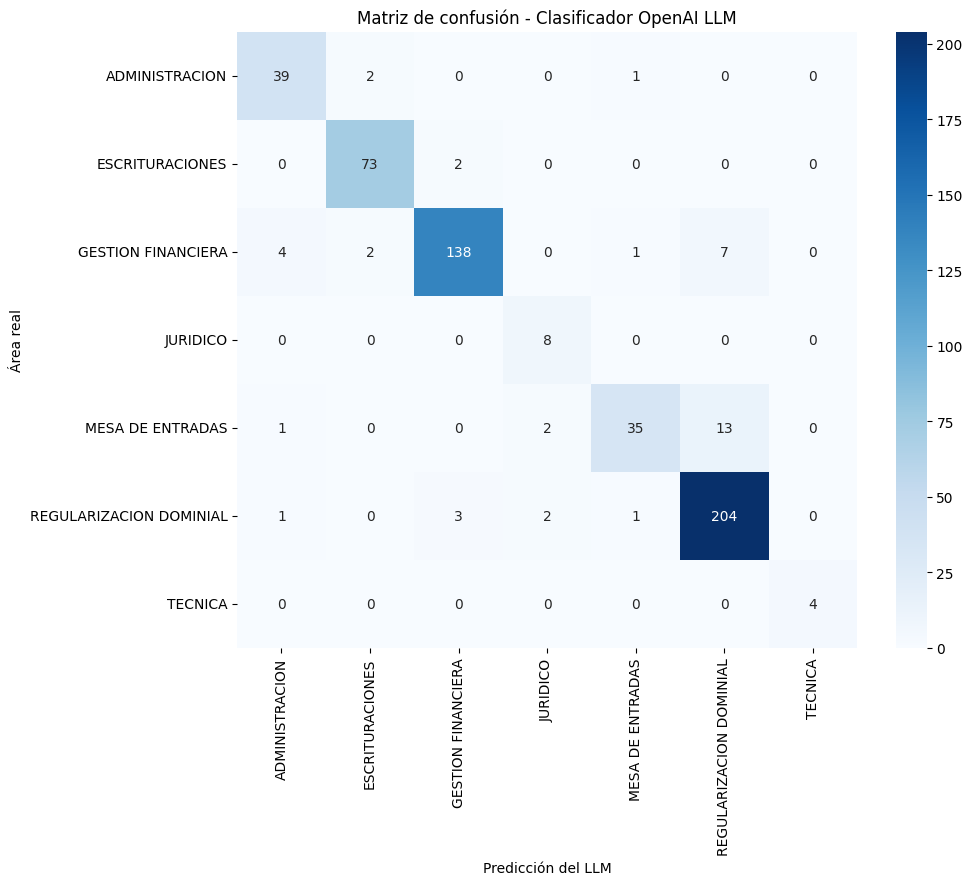

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = sorted(y_true.unique())  # lista de áreas en orden alfabético

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicción del LLM")
plt.ylabel("Área real")
plt.title("Matriz de confusión - Clasificador OpenAI LLM")
plt.show()

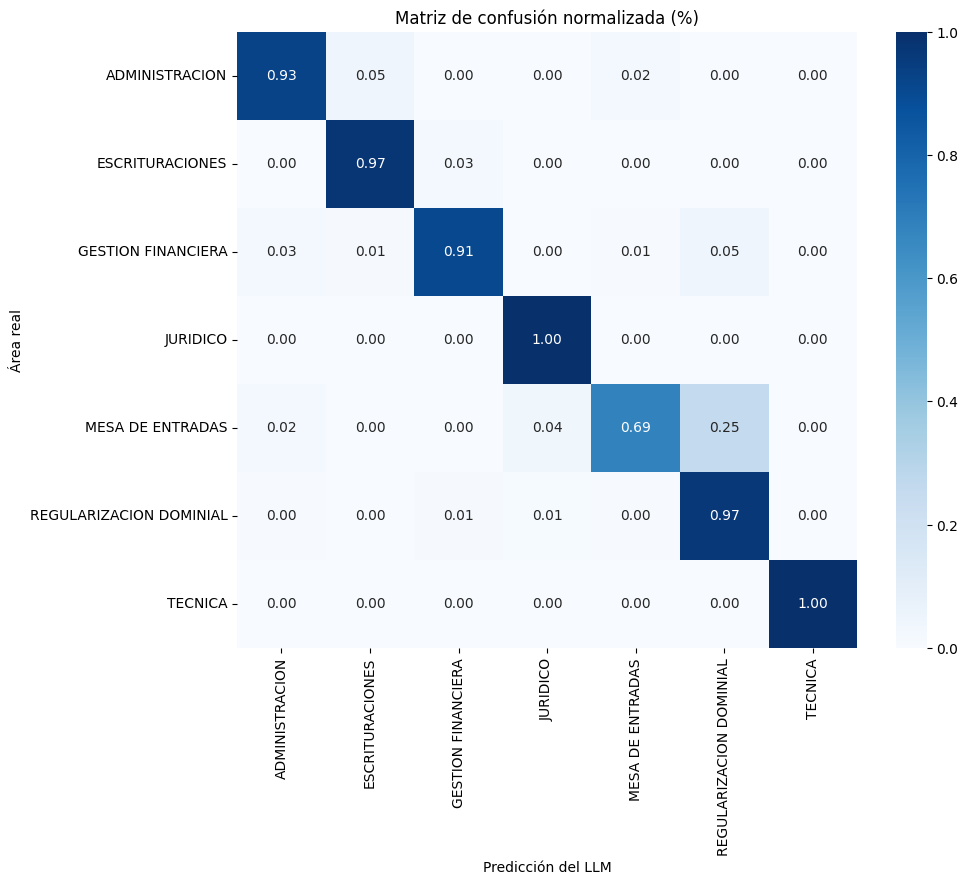

In [ ]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicción del LLM")
plt.ylabel("Área real")
plt.title("Matriz de confusión normalizada (%)")
plt.show()

In [ ]:
df_asuntos_llm

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada,area_pred_llm,area_objetivo_nombre
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0,MESA DE ENTRADAS,MESA DE ENTRADAS
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2,REGULARIZACION DOMINIAL,GESTION FINANCIERA
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3,ADMINISTRACION,ADMINISTRACION
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
...,...,...,...,...,...,...,...,...
751,31/07/2025,turno escritura,ESCRITURACIONES,False,False,4,ESCRITURACIONES,ESCRITURACIONES
752,31/07/2025,escritura de mi terreno segundo testimonio,ESCRITURACIONES,False,False,4,ESCRITURACIONES,ESCRITURACIONES
753,31/07/2025,ponerme al dia con mi deuda,GESTION FINANCIERA,False,False,2,GESTION FINANCIERA,GESTION FINANCIERA
754,31/07/2025,direccion de vivienda - solicita inscripcion d...,REGULARIZACION DOMINIAL,False,False,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL


#### Des-comentar en caso de querer guardar resultados

In [ ]:
# df_asuntos_llm.to_csv("resultados_llm_completos.csv", index=False, encoding="utf-8")
# print("Archivo guardado como resultados_llm_completos.csv")

Archivo guardado como resultados_llm_completos.csv


# Revisamos datos

In [ ]:
df_check = pd.read_csv("resultados_llm_completos.csv")
df_check.head()

,Fecha de creación,asunto,area_objetivo,es_dup_exacto,es_dup_asunto_en_area,area_objetivo_codificada,area_pred_llm,area_objetivo_nombre
0,8/9/2025,adjuntar documentacion solicitada,MESA DE ENTRADAS,True,True,0,MESA DE ENTRADAS,MESA DE ENTRADAS
1,8/9/2025,cambio de titularidad para adjudicatarios,REGULARIZACION DOMINIAL,True,True,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL
2,8/9/2025,cancelacion de hipoteca,GESTION FINANCIERA,True,True,2,REGULARIZACION DOMINIAL,GESTION FINANCIERA
3,8/9/2025,combustible para vehiculos oficiales - petrole...,ADMINISTRACION,False,False,3,ADMINISTRACION,ADMINISTRACION
4,8/9/2025,cupon de pago - cambio de titularidad,REGULARIZACION DOMINIAL,False,False,1,REGULARIZACION DOMINIAL,REGULARIZACION DOMINIAL


 MÉTRICAS GENERALES DEL MODELO LLM

Accuracy top-1: 0.9226519337016574

Reporte de clasificación:

                         precision    recall  f1-score   support

         ADMINISTRACION       0.87      0.93      0.90        42
        ESCRITURACIONES       0.95      0.97      0.96        75
     GESTION FINANCIERA       0.97      0.91      0.94       152
               JURIDICO       0.67      1.00      0.80         8
       MESA DE ENTRADAS       0.92      0.69      0.79        51
REGULARIZACION DOMINIAL       0.91      0.97      0.94       211
                TECNICA       1.00      1.00      1.00         4

               accuracy                           0.92       543
              macro avg       0.90      0.92      0.90       543
           weighted avg       0.93      0.92      0.92       543


 MATRIZ DE CONFUSIÓN



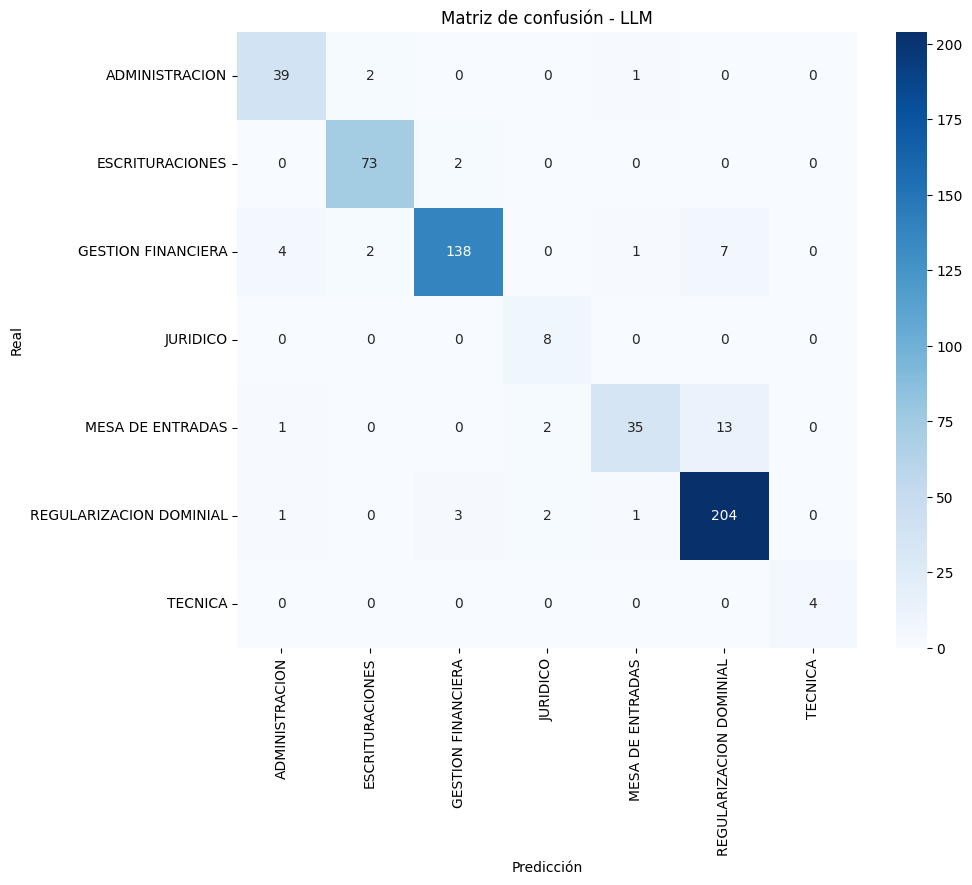

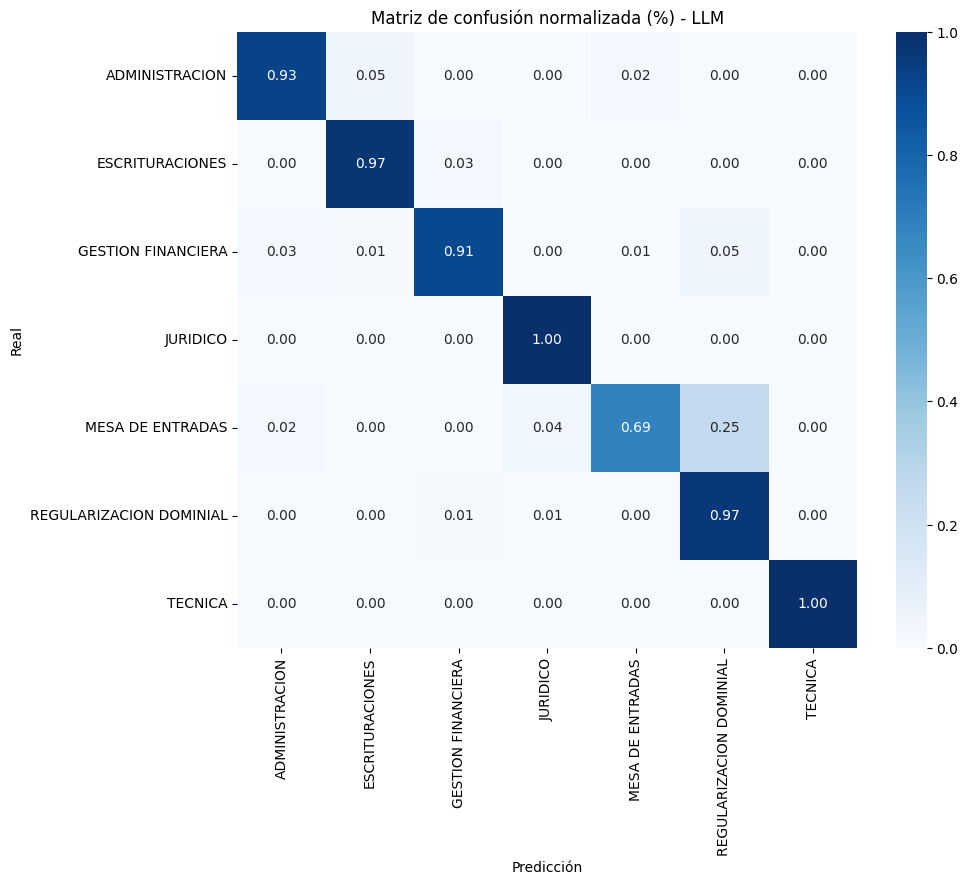


 TOP ERRORES (primeros 15)



,asunto,area_objetivo_nombre,area_pred_llm
2,cancelacion de hipoteca,GESTION FINANCIERA,REGULARIZACION DOMINIAL
20,solicitud terreno,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
49,propiedad vendida,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
55,terreno del lote lo tengo,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
90,notificacion de duda,GESTION FINANCIERA,MESA DE ENTRADAS
102,vivienda marques sobremonte,MESA DE ENTRADAS,REGULARIZACION DOMINIAL
124,adjunto pago de arancel de cambio de titularidad,REGULARIZACION DOMINIAL,ADMINISTRACION
129,servicios medicos y sanitarios - sistema de urgencias del rosafe s.a.u.,ADMINISTRACION,MESA DE ENTRADAS
160,adjunto documentacion solicitada. sentencia de divorcio,MESA DE ENTRADAS,JURIDICO
178,cancelar lote mario etcheverri,GESTION FINANCIERA,REGULARIZACION DOMINIAL



 ACCURACY POR ÁREA



/tmp/ipython-input-3850211923.py:93: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["area_pred_llm"] == x["area_objetivo_nombre"]).mean())


,0
area_objetivo_nombre,
JURIDICO,1.000000
TECNICA,1.000000
ESCRITURACIONES,0.973333
REGULARIZACION DOMINIAL,0.966825
ADMINISTRACION,0.928571
GESTION FINANCIERA,0.907895
MESA DE ENTRADAS,0.686275


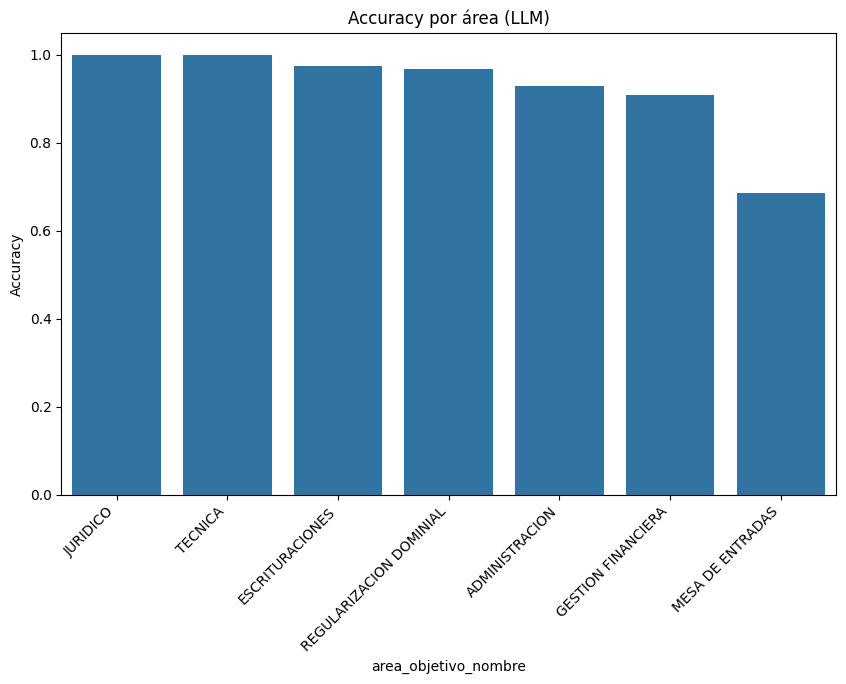


 MATRIZ DE CONFUSIÓN (crudo)



,ADMINISTRACION,ESCRITURACIONES,GESTION FINANCIERA,JURIDICO,MESA DE ENTRADAS,REGULARIZACION DOMINIAL,TECNICA
ADMINISTRACION,39,2,0,0,1,0,0
ESCRITURACIONES,0,73,2,0,0,0,0
GESTION FINANCIERA,4,2,138,0,1,7,0
JURIDICO,0,0,0,8,0,0,0
MESA DE ENTRADAS,1,0,0,2,35,13,0
REGULARIZACION DOMINIAL,1,0,3,2,1,204,0
TECNICA,0,0,0,0,0,0,4



 INTERPRETACIÓN BÁSICA:


• Filas = área real
• Columnas = predicción del modelo

• Si una fila tiene muchas predicciones en otra columna → confusión frecuente 
  (ej: Regularización → Administración significa que muchas cosas de RD
   se clasifican como Administración).

• Si la diagonal es alta → buen rendimiento general.


 PALABRAS FRECUENTES EN ERRORES

Top 50 palabras frecuentes en asuntos mal clasificados:

de: 24
lote: 7
y: 6
solicitud: 5
terreno: 5
vivienda: 5
cancelacion: 4
del: 4
cancelar: 4
pagar: 4
para: 4
mi: 4
quiero: 4
pago: 3
casa: 3
barrio: 3
habitacional: 3
escriturar: 3
solicito: 3
con: 3
ref: 3
lo: 2
tengo: 2
marques: 2
sobremonte: 2
adjunto: 2
cambio: 2
a: 2
documentacion: 2
sentencia: 2
divorcio: 2
cuenta: 2
regularizar: 2
el: 2
titular: 2
cuotas: 2
mza: 2
por: 2
bloqueada: 2
direccion: 2
plan: 2
libre: 2
deuda: 2
una: 2
baja: 2
renuncia: 2
hipoteca: 1
propiedad: 1
vendida: 1
notificacion: 1


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

# === 1. CARGA DE DATOS ===

# Ya tenés el df_check en memoria
df = df_check.copy()

y_true = df["area_objetivo_nombre"]
y_pred = df["area_pred_llm"]

labels = sorted(df["area_objetivo_nombre"].unique())


# === 2. MÉTRICAS GENERALES ===

print("====================================")
print(" MÉTRICAS GENERALES DEL MODELO LLM")
print("====================================\n")

print("Accuracy top-1:", accuracy_score(y_true, y_pred))
print("\nReporte de clasificación:\n")
print(classification_report(y_true, y_pred))


# === 3. MATRIZ DE CONFUSIÓN ===

print("\n====================================")
print(" MATRIZ DE CONFUSIÓN")
print("====================================\n")

cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Matriz de confusión - LLM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === MATRIZ NORMALIZADA ===

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.title("Matriz de confusión normalizada (%) - LLM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


# === 4. ERRORES MÁS IMPORTANTES ===

df_errores = df[df["area_objetivo_nombre"] != df["area_pred_llm"]]

print("\n====================================")
print(" TOP ERRORES (primeros 15)")
print("====================================\n")

pd.set_option('display.max_colwidth', None)
display(df_errores[["asunto", "area_objetivo_nombre", "area_pred_llm"]].head(15))


# === 5. ANALISIS DE ACCURACY POR ÁREA ===

print("\n====================================")
print(" ACCURACY POR ÁREA")
print("====================================\n")

accuracy_por_area = (
    df.groupby("area_objetivo_nombre")
    .apply(lambda x: (x["area_pred_llm"] == x["area_objetivo_nombre"]).mean())
    .sort_values(ascending=False)
)

display(accuracy_por_area)

plt.figure(figsize=(10,6))
sns.barplot(x=accuracy_por_area.index, y=accuracy_por_area.values)
plt.title("Accuracy por área (LLM)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.show()


# === 6. ÁREAS QUE MÁS SE CONFUNDEN ENTRE SÍ ===

print("\n====================================")
print(" MATRIZ DE CONFUSIÓN (crudo)")
print("====================================\n")

df_conf = pd.DataFrame(cm, index=labels, columns=labels)
display(df_conf)


print("\n====================================")
print(" INTERPRETACIÓN BÁSICA:")
print("====================================\n")
print("""
• Filas = área real
• Columnas = predicción del modelo

• Si una fila tiene muchas predicciones en otra columna → confusión frecuente
  (ej: Regularización → Administración significa que muchas cosas de RD
   se clasifican como Administración).

• Si la diagonal es alta → buen rendimiento general.
""")


# === 7. ANÁLISIS LÉXICO DE ERRORES ===

print("\n====================================")
print(" PALABRAS FRECUENTES EN ERRORES")
print("====================================\n")

from collections import Counter
import re

def limpiar(texto):
    if pd.isna(texto):
        return ""
    return re.sub(r"[^a-zA-Záéíóúñü\s]", " ", texto.lower())

errores_textos = df_errores["asunto"].apply(limpiar).str.split()

counter = Counter()
for palabras in errores_textos:
    counter.update(palabras)

print("Top 50 palabras frecuentes en asuntos mal clasificados:\n")
for palabra, freq in counter.most_common(50):
    print(f"{palabra}: {freq}")


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords

stopwords_es = set(stopwords.words('spanish'))


In [ ]:
stopwords_custom = {
    "sr", "sra", "señor", "señora", "vecino", "vecina",
    "nota", "tramite", "trámite", "documento",
    "solicita", "solicito", "presenta", "presento",
    "pide", "adjunta", "adjunto", "solicitud",
    "expediente", "expte", "exp",
    "beneficiario", "beneficiaria", "de", "del"
}

stopwords_total = stopwords_es.union(stopwords_custom)


In [ ]:
from collections import Counter
import re

def limpiar(texto):
    if pd.isna(texto):
        return ""
    return re.sub(r"[^a-záéíóúñüA-ZÁÉÍÓÚÑÜ\s]", " ", texto.lower())

errores_textos = df_errores["asunto"].apply(limpiar).str.split()

counter = Counter()

for palabras in errores_textos:
    palabras_filtradas = [
        p for p in palabras
        if p not in stopwords_total and len(p) > 2
    ]
    counter.update(palabras_filtradas)

print("Top 50 palabras (sin stopwords) en asuntos mal clasificados:\n")
for palabra, freq in counter.most_common(50):
    print(f"{palabra}: {freq}")


Top 50 palabras (sin stopwords) en asuntos mal clasificados:

lote: 7
terreno: 5
vivienda: 5
cancelacion: 4
cancelar: 4
pagar: 4
quiero: 4
pago: 3
casa: 3
barrio: 3
habitacional: 3
escriturar: 3
ref: 3
marques: 2
sobremonte: 2
cambio: 2
documentacion: 2
sentencia: 2
divorcio: 2
cuenta: 2
regularizar: 2
titular: 2
cuotas: 2
mza: 2
bloqueada: 2
direccion: 2
plan: 2
libre: 2
deuda: 2
baja: 2
renuncia: 2
hipoteca: 1
propiedad: 1
vendida: 1
notificacion: 1
duda: 1
arancel: 1
titularidad: 1
servicios: 1
medicos: 1
sanitarios: 1
sistema: 1
urgencias: 1
rosafe: 1
solicitada: 1
mario: 1
etcheverri: 1
lilas: 1
intervencion: 1
audiencia: 1


In [ ]:
df_asuntos_llm = df.copy()

In [ ]:
import os
from datetime import datetime

def crear_carpeta_experimento(nombre_base="experimento"):
    # Fecha para versionado automático
    fecha = datetime.now().strftime("%Y%m%d_%H%M%S")
    carpeta = f"/content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/{nombre_base}_{fecha}/"
    os.makedirs(carpeta, exist_ok=True)
    return carpeta


In [ ]:
def guardar_resultados(carpeta_experimento, df_resultados):
    ruta = os.path.join(carpeta_experimento, "resultados.csv")
    df_resultados.to_csv(ruta, index=False, encoding="utf-8")
    print(f"✔ Resultados guardados en: {ruta}")


In [ ]:
import json

def guardar_metricas(
    carpeta_experimento,
    accuracy,
    classification_report_text,
    parametros_modelo,
    descripcion_experimento=""
):
    metricas = {
        "accuracy": accuracy,
        "classification_report": classification_report_text,
        "parametros_modelo": parametros_modelo,
        "descripcion": descripcion_experimento
    }

    ruta_json = os.path.join(carpeta_experimento, "metricas.json")
    with open(ruta_json, "w", encoding="utf-8") as f:
        json.dump(metricas, f, indent=4, ensure_ascii=False)

    print(f"✔ Métricas guardadas en: {ruta_json}")


In [ ]:
parametros_modelo = {
    "tipo": "Clasificador LLM - OpenAI - Base",
    "descripción":"API de OpenAi, Asunto y propmt con la descripcion de las Areas",
    "modelo": "gpt-4.1-mini",
    "instrucciones_especiales": True,
    "jerarquia_reglas": False,
    "cantidad_asuntos": len(df_asuntos_llm)
}


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

# 1. Crear carpeta del experimento
carpeta = crear_carpeta_experimento("experimento_llm_prioridad")

# 2. Guardar resultados completos
guardar_resultados(carpeta, df_asuntos_llm)

# 3. Calcular métricas
y_true = df_asuntos_llm["area_objetivo_nombre"]
y_pred = df_asuntos_llm["area_pred_llm"]

accuracy = accuracy_score(y_true, y_pred)
clas_report_text = classification_report(y_true, y_pred)

# 4. Guardar métricas y descripción
descripcion = """
API de OpenAi, Asunto y propmt con la descripcion de las Areas
"""

guardar_metricas(
    carpeta,
    accuracy,
    clas_report_text,
    parametros_modelo,
    descripcion
)


✔ Resultados guardados en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_llm_prioridad_20251128_023720/resultados.csv
✔ Métricas guardadas en: /content/drive/MyDrive/Diplo-2025/Proyecto/Clasificacion_Asuntos/experimento_llm_prioridad_20251128_023720/metricas.json
